In [90]:
import matplotlib.pyplot as plt

In [91]:
from sklearn.datasets import make_blobs, make_circles
from sklearn.model_selection import train_test_split

In [92]:
X, y = make_circles(n_samples=500, factor=0.3, noise=0.2, random_state=1)

Here we use a routine provided by sklearn for splitting the dataset.

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

## Plot data

It is always a good first step to plot the data to get some visual insights.

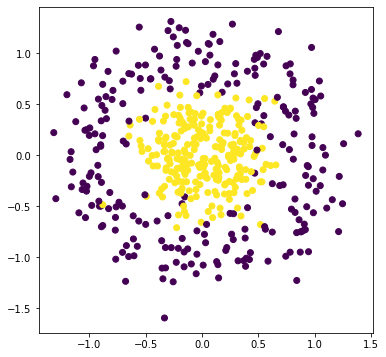

In [94]:
fig = plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c=y)

Similar, we can also plot the train or test data.

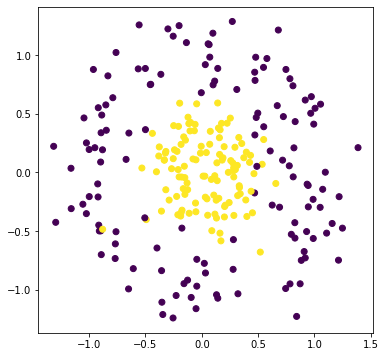

In [95]:
fig = plt.figure(figsize=(6,6))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)

# Pytorch

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

### Step 0: Load models for random dynamical systems


In [120]:
def PM_map(x, gamma=0.7):
  if x < 0.5:
    return x*(1+(2**gamma)*(x**gamma))
  else:
    return 2*x-1

def Thaler_map(x, gamma=0.6):
  return (x*(1+(x/(1+x))**(gamma-1) - x**(gamma-1))**(1/(1-gamma))) % 1

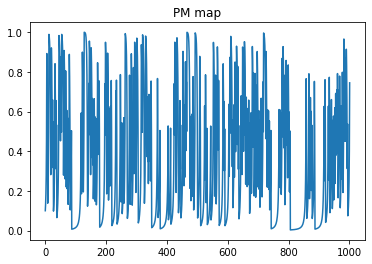

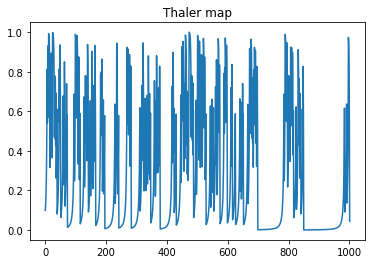

In [137]:
#visualization
PM_iters = []
x = 0.1
PM_iters.append(x)
for i in range(1001):
  x = PM_map(x,0.7)
  PM_iters.append(x)
  
plt.plot(PM_iters)
plt.title('PM map')
plt.show()

thaler_iters = []
x = 0.1
thaler_iters.append(x)
for i in range(1001):
  x = Thaler_map(x)
  thaler_iters.append(x)

plt.plot(thaler_iters)
plt.title('Thaler map')
plt.show()

### Step 1: Create a torch data loader

In [99]:
BATCH_SIZE = 50 # define batch size

In [100]:
dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_train, dtype=torch.float),
    torch.tensor(y_train, dtype=torch.float).reshape(-1,1))

train_loader = torch.utils.data.DataLoader(dataset,batch_size=BATCH_SIZE)
test_target = torch.tensor(y_test, dtype=torch.float).reshape(-1,1)

### Step 2: Build a Network

In [101]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 32)  # input layer
        self.fc2 = nn.Linear(32, 32) # hidden layer
        self.fc3 = nn.Linear(32, 1)  # ouput layer
        
        self.layers = [self.fc1, self.fc2]

    def forward(self, x):
        
        for i, layer in enumerate(self.layers):
            x = layer(x)
            x = F.relu(x)
        x = torch.sigmoid(self.fc3(x))
        return x

### Step 4: Train the Model

In [134]:
def train(lr=0.1, epochs=100, option=0):
    
    np.random.seed(1)
    torch.manual_seed(1)
    torch.cuda.manual_seed(1)
    torch.cuda.manual_seed_all(1)
    
    if option == 1:
      gamma = 0.7
      r = 0.1 #(0.01)**gamma
    elif option == 2:
      gamma = 0.6
      r = 0.1 #(0.01)**gamma

    net = Net()
    print(net)

    """Train for one epoch."""
    net.train()
    loss_ema = 0.

    optimizer = optim.AdamW(net.parameters(), lr=lr, weight_decay=0.0001)

    criterion = nn.BCELoss() # Sigmoid layer + Binary Cross Entropy

    train_loss_hist = []
    test_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []
    count = 0

    for epoch in range(1, epochs):
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            outputs = net(inputs)      

            if option == 0:
                loss = criterion(outputs, targets)  
            elif option == -1:
                reg = 0.0
                for param in net.parameters():
                    reg += 0.001 * (param ** 2).sum()
                loss = criterion(outputs, targets) + reg
            else:
                reg = 0.0
                for param in net.parameters():
                    reg += 0.01 * (param ** 2).sum()
                loss = criterion(outputs, targets) + r * reg #/(1+0.02*count)
                if option == 1:
                    r = PM_map(r,gamma=gamma)
                elif option == 2:
                    r = Thaler_map(r,gamma=gamma)
                else:
                    print('Invalid option!')
                count += 1  


            loss.backward()        
            optimizer.step()
            optimizer.zero_grad()
            
        #evaluate
        net.eval()
        y_pred = net(torch.from_numpy(X_test).float())
        test_loss = criterion(y_pred, test_target)
        y_pred = y_pred.detach().numpy()
        y_pred[y_pred>=0.5] = 1.0
        y_pred[y_pred<0.5] = 0.0

        train_loss_hist.append(loss)
        test_loss_hist.append(test_loss)
        test_acc_hist.append(accuracy_score(y_test, y_pred))

        if epoch % 50 == 0: print('Epoch: %s, Train loss: %s', (epoch, train_loss_hist[-1]))
        if epoch % 50 == 0: print('Epoch: %s, Test loss: %s', (epoch, test_loss_hist[-1]))
        if epoch % 50 == 0: print('Epoch: %s, Test accuracy: %s', (epoch, test_acc_hist[-1]))
    
    plt.plot(train_loss_hist)
    plt.ylabel('train loss', fontsize=20)
    plt.xlabel('epoch', fontsize=20)
    plt.show()
    
    plt.plot(test_loss_hist)
    plt.ylabel('test loss', fontsize=20)
    plt.xlabel('epoch', fontsize=20)
    plt.show()

    plt.plot(test_acc_hist)
    plt.ylabel('test accuracy', fontsize=20)
    plt.xlabel('epoch', fontsize=20)
    plt.show()

    return net

In [103]:
def evaluate(net):
    net.eval()
    y_pred = net(torch.from_numpy(X_test).float())
    y_pred = y_pred.detach().numpy()
    y_pred[y_pred>=0.5] = 1.0
    y_pred[y_pred<0.5] = 0.0

    from sklearn.metrics import accuracy_score
    print('Test acc: ', accuracy_score(y_test, y_pred))

In [104]:
def plot(net, name='baseline'):
   # Adding decision boundary to plot
    x1 = np.arange(-1.8, 1.8, 0.1)
    x2 = np.arange(-1.8, 1.8, 0.1)
    Z = np.zeros((len(x1),len(x2)))
    net.eval()
    for i in range(len(x1)):
        for j in range(len(x2)):
            pred = net(torch.from_numpy(np.array([x1[i], x2[j]]).reshape(1, -1)).float())
            pred = pred.detach().numpy()
            Z[i,j] = pred 
        
    fig = plt.figure(figsize=(6,5))
    colors = np.array(['#2b8cbe','#31a354'])
    plt.contourf(x1, x2, Z.T, alpha=0.4, vmin=0, vmax=1, cmap='PuRd')
    #plt.colorbar()
    plt.scatter(X[:,0], X[:,1], c=colors[y], alpha=0.5)
    plt.ylim(-1.4,1.4)
    plt.xlim(-1.4,1.4)
    plt.axis('off')
    plt.tight_layout()
    #plt.savefig('toy_'+name+'.pdf')

# Baseline

Net(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)
Epoch: %s, Train loss: %s (50, tensor(0.1761, grad_fn=<BinaryCrossEntropyBackward0>))
Epoch: %s, Test loss: %s (50, tensor(0.5528, grad_fn=<BinaryCrossEntropyBackward0>))
Epoch: %s, Test accuracy: %s (50, 0.884)


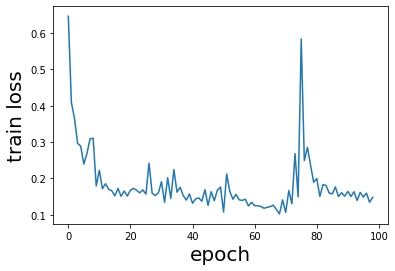

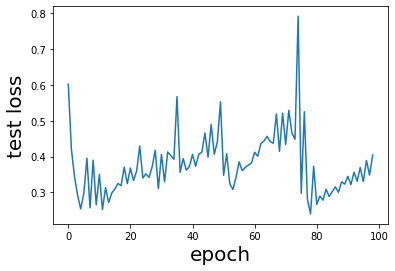

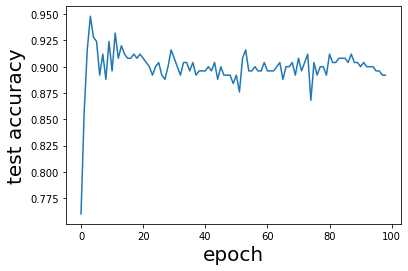

Test acc:  0.892


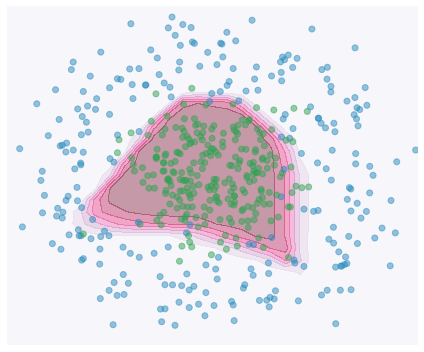

In [105]:
net = train(lr=0.1, epochs=100)

evaluate(net)
plot(net, name='baseline')

# Option 1: PM map


Net(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)
Epoch: %s, Train loss: %s (50, tensor(0.2437, grad_fn=<AddBackward0>))
Epoch: %s, Test loss: %s (50, tensor(0.2044, grad_fn=<BinaryCrossEntropyBackward0>))
Epoch: %s, Test accuracy: %s (50, 0.916)


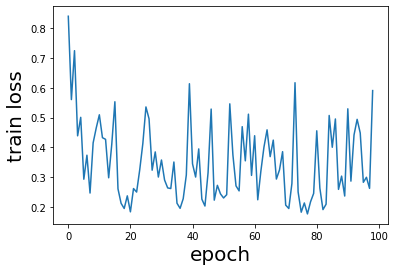

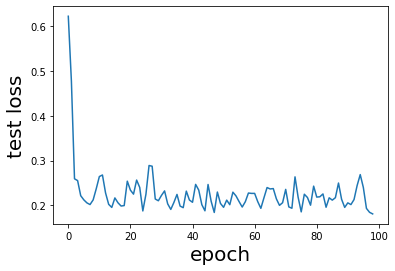

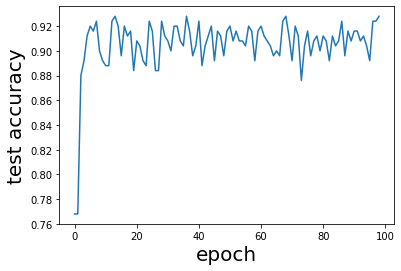

Test acc:  0.928


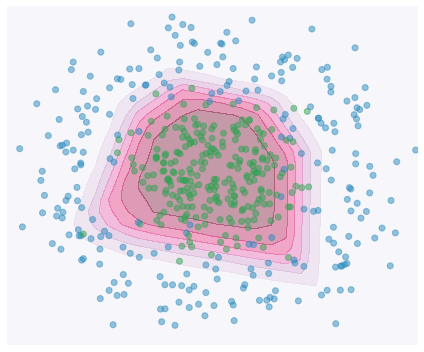

In [135]:
net = train(lr=0.1, epochs=100, option=1)

evaluate(net)
plot(net, name='with PM map')

# Option 2: Thaler map

Net(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)
Epoch: %s, Train loss: %s (50, tensor(0.1985, grad_fn=<AddBackward0>))
Epoch: %s, Test loss: %s (50, tensor(0.2014, grad_fn=<BinaryCrossEntropyBackward0>))
Epoch: %s, Test accuracy: %s (50, 0.912)


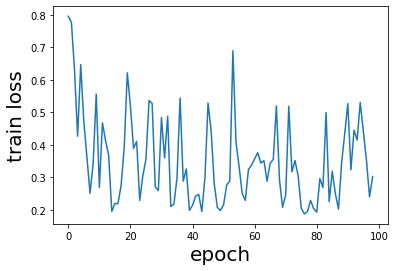

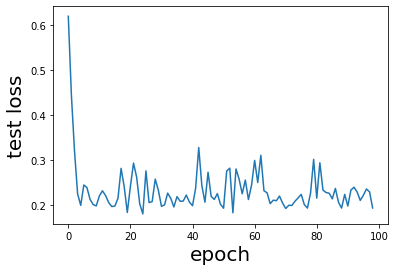

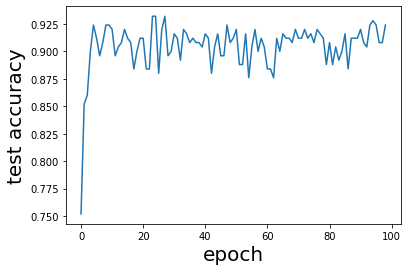

Test acc:  0.924


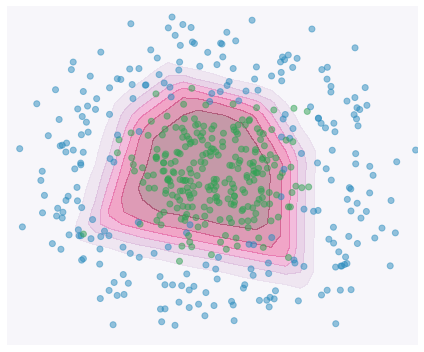

In [136]:
net = train(lr=0.1, epochs=100, option=2)

evaluate(net)
plot(net, name='with Thaler map')

# With Standard Regularization



Net(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)
Epoch: %s, Train loss: %s (50, tensor(0.2149, grad_fn=<AddBackward0>))
Epoch: %s, Test loss: %s (50, tensor(0.2295, grad_fn=<BinaryCrossEntropyBackward0>))
Epoch: %s, Test accuracy: %s (50, 0.9)


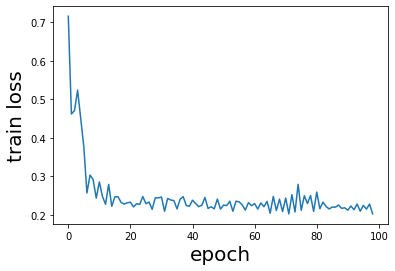

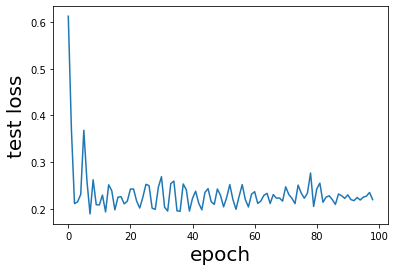

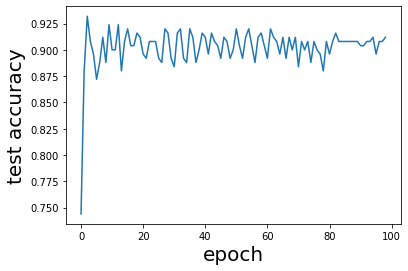

Test acc:  0.912


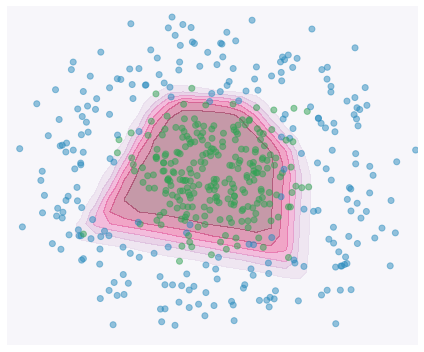

In [126]:
net = train(lr=0.1, epochs=100, option=-1)

evaluate(net)
plot(net, name='with standard regularization')

#### Compared with baseline training and training with standard regularization, training with option 1 and 2 makes the training loss bigger and fluctuates wilder, BUT they both increase classification accuracy and leading to smoother decision boundary.